In [ ]:
import pandas as pd
import os
import seaborn as sns
import numpy as np

In [ ]:
SAVE_BASE_DIR = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/mzLearn_preTraining/data_2024_July_11' #Leila owns the mzlearn_preTraining folder


In [ ]:
all_metadata_list = []
for metab_study_name in all_study_id_list:
    load_dir = f'{SAVE_BASE_DIR}/{metab_study_name}'
    if not os.path.exists(f'{load_dir}/metadata.csv'):
        print(f'{metab_study_name} is missing')
        continue
    metadata = pd.read_csv(f'{load_dir}/metadata.csv', index_col=0)

    all_metadata_list.append(metadata)

all_metadata = pd.concat(all_metadata_list)
all_metadata['is Female']  = all_metadata['Sex'].map({'F':1, 'M':0})

In [ ]:
all_metadata['Pretrain All'] = True
all_metadata['Finetune All'] = False
rcc3_baseline = all_metadata[(all_metadata['Study ID'] == 'ST001237') & (all_metadata['Timepoint']=='baseline')].index.to_list()
all_metadata.loc[rcc3_baseline,'Pretrain All'] = False
all_metadata.loc[rcc3_baseline,'Finetune All'] = True

In [ ]:
all_metadata['Sample_Class'].value_counts()

Sample_Class
Study_Sample       3272
Study_sample       2514
Study_QAQC          486
Study_QC_Sample     473
PooledQAQC          449
Pooled_Plasma        34
NIST1950              6
NIST_1950             6
Name: count, dtype: int64

In [ ]:
qc_samples = all_metadata[(all_metadata['Sample_Class']=='NIST1950') | 
                            (all_metadata['Sample_Class']=='NIST_1950') |
                            (all_metadata['Sample_Class']=='Study_QC_Sample') |
                            (all_metadata['Sample_Class']=='Study_QAQC')].index.to_list()

all_metadata.loc[qc_samples,'Pretrain All'] = False
all_metadata.loc[qc_samples,'Finetune All'] = False       

In [ ]:
if 'Matt Set Label' not in all_metadata.columns:
    print('Warning: Matt Set Label not in metadata')

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedGroupKFold


def smart_trainval_split(metadata, suffix='Pretrain All',stratify_cols=['Study ID','Sex'],test_frac=0.1):
    metadata.dropna(axis=1, how='all', inplace=True)
    y = metadata[metadata[f'{suffix}']].copy()
    y = y[stratify_cols+['Subject ID']].copy()

    if 'Subject ID' in y.columns:
        y_with_sample_id = y[~y['Subject ID'].isna()].copy()
        y_with_sample_id['Subject ID'] = y_with_sample_id['Subject ID'].astype(str)
        y_without_sample_id = y[y['Subject ID'].isna()].copy()
    else:
        y_with_sample_id = pd.DataFrame(index=y.index)
        y_without_sample_id = y

    # fill missing value of numeric columns with -1
    numeric_cols = y_without_sample_id.select_dtypes(include=[np.number]).columns
    y_without_sample_id[numeric_cols] = y_without_sample_id[numeric_cols].fillna(-1)
    y_with_sample_id[numeric_cols] = y_with_sample_id[numeric_cols].fillna(-1)

    # fill missing value of non-numeric columns with 'missing'
    non_numeric_cols = y_without_sample_id.select_dtypes(exclude=[np.number]).columns
    y_without_sample_id[non_numeric_cols] = y_without_sample_id[non_numeric_cols].fillna('missing')
    y_with_sample_id[non_numeric_cols] = y_with_sample_id[non_numeric_cols].fillna('missing')

    n_splits = round(1/test_frac)

    if len(y_with_sample_id) > 0:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, random_state=42, shuffle=True)
        # print(y)
        if len(stratify_cols) > 1:
            train_inds, val_inds = next(sgkf.split(y_with_sample_id, y_with_sample_id[stratify_cols[0]], groups=y_with_sample_id['Subject ID']))
        else:
            train_inds, val_inds = next(sgkf.split(y_with_sample_id, y_with_sample_id[stratify_cols], groups=y_with_sample_id['Subject ID']))

        train_ids1 = y_with_sample_id.index[train_inds].to_list()
        val_ids1 = y_with_sample_id.index[val_inds].to_list()
    else:
        train_ids1 = []
        val_ids1 = []


    if len(y_without_sample_id) > 0:
        train_ids2, val_ids2 = train_test_split(y_without_sample_id.index, test_size=test_frac, stratify=y_without_sample_id[stratify_cols], random_state=42)
        train_ids2 = train_ids2.tolist()
        val_ids2 = val_ids2.tolist()
    else:
        train_ids2 = []
        val_ids2 = []

    train_ids = train_ids1 + train_ids2
    val_ids = val_ids1 + val_ids2

    return train_ids, val_ids


def assign_sets(metadata, preset_finetune_col='Matt Set Label'):
    train_ids, val_ids = smart_trainval_split(metadata, suffix='Pretrain All')
    metadata['Pretrain Discovery'] = False
    metadata['Pretrain Test'] = False
    metadata.loc[train_ids,'Pretrain Discovery'] = True
    metadata.loc[val_ids,'Pretrain Test'] = True

    train_ids, val_ids = smart_trainval_split(metadata, suffix='Pretrain Discovery')
    metadata['Pretrain Discovery Train'] = False
    metadata['Pretrain Discovery Val'] = False
    metadata.loc[train_ids,'Pretrain Discovery Train'] = True
    metadata.loc[val_ids,'Pretrain Discovery Val'] = True

    if preset_finetune_col not in metadata.columns:
        train_ids, val_ids = smart_trainval_split(metadata, suffix='Finetune All', stratify_cols=['IMDC','MSKCC'])
        metadata['Finetune Discovery'] = False
        metadata['Finetune Test'] = False
        metadata.loc[train_ids,'Finetune Discovery'] = True
        metadata.loc[val_ids,'Finetune Test'] = True

        train_ids, val_ids = smart_trainval_split(metadata, suffix='Finetune Discovery', stratify_cols=['IMDC','MSKCC'])
        metadata['Finetune Discovery Train'] = False
        metadata['Finetune Discovery Val'] = False
        metadata.loc[train_ids,'Finetune Discovery Train'] = True
        metadata.loc[val_ids,'Finetune Discovery Val'] = True
    
    else:
        print(f'found {preset_finetune_col} in metadata, using this to assign finetune sets')
        train_ids = metadata[(metadata[preset_finetune_col]=='Train') & (metadata['Finetune All'])].index.to_list()
        val_ids = metadata[(metadata[preset_finetune_col]=='Val') & (metadata['Finetune All'])].index.to_list()
        disc_ids = train_ids + val_ids
        test_ids = metadata[(metadata[preset_finetune_col]=='Test') & (metadata['Finetune All'])].index.to_list()
        metadata['Finetune Discovery'] = False
        metadata['Finetune Test'] = False
        metadata.loc[disc_ids,'Finetune Discovery'] = True
        metadata.loc[test_ids,'Finetune Test'] = True

        metadata['Finetune Discovery Train'] = False
        metadata['Finetune Discovery Val'] = False
        metadata.loc[train_ids,'Finetune Discovery Train'] = True
        metadata.loc[val_ids,'Finetune Discovery Val'] = True

        

    metadata['Set'] = 'skip'
    metadata.loc[metadata['Pretrain Discovery Train'],'Set'] = 'Pretrain Discovery Train'
    metadata.loc[metadata['Pretrain Discovery Val'],'Set'] = 'Pretrain Discovery Val'
    metadata.loc[metadata['Pretrain Test'],'Set'] = 'Pretrain Test'
    metadata.loc[metadata['Finetune Discovery Train'],'Set'] = 'Finetune Discovery Train'
    metadata.loc[metadata['Finetune Discovery Val'],'Set'] = 'Finetune Discovery Val'
    metadata.loc[metadata['Finetune Test'],'Set'] = 'Finetune Test'


    if not (metadata['Set'].value_counts().sum() == metadata.shape[0]):
        print('Error in assigning the sets, some samples assigned to more than one set')
        
    return metadata


def get_selection_df(metadata):
    selection_cols = ['Set'] + [x for x in metadata.columns if 'Pretrain' in x or 'Finetune' in x]
    selection_df = metadata[selection_cols].copy()
    return selection_df


In [ ]:
all_metadata = assign_sets(all_metadata)

found Matt Set labels for RCC3 fintune


In [ ]:
all_metadata['Set'].value_counts()

Set
Pretrain Discovery Train    16862
Pretrain Test                2060
Pretrain Discovery Val       1905
skip                          971
Finetune Discovery Train      450
Finetune Test                 147
Finetune Discovery Val        144
Name: count, dtype: int64

In [ ]:
all_metadata['Pretrain All'].value_counts()

Pretrain All
True     20827
False     1712
Name: count, dtype: int64

In [ ]:
nan_subject_ids = all_metadata[all_metadata['Subject ID'].isna()].index.to_list()
num_nan_subject_ids = len(nan_subject_ids)
num_unique_real_subject_ids = all_metadata['Subject ID'].nunique()
num_pool_samples = all_metadata['Sample_Class'].str.contains('Pool').sum()
num_skip_samples = (all_metadata['Set'] == 'skip').sum()

# note: not all the pool samples are identified by 'Sample_Class" 
tot_num_subject_ids = num_nan_subject_ids + num_unique_real_subject_ids - num_pool_samples - num_skip_samples

print(f'Number of samples with missing Subject ID: {num_nan_subject_ids}')
print(f'Number of unique real Subject IDs: {num_unique_real_subject_ids}')
print(f'Number of pool samples: {num_pool_samples}')
print(f'Total number of unqiue: {tot_num_subject_ids}')

Number of samples with missing Subject ID: 12184
Number of unique real Subject IDs: 3400
Number of pool samples: 483
Total number of unqiue: 14130


In [ ]:
# if any BMI value is not numeric, replace it with nan
all_metadata['BMI'] = pd.to_numeric(all_metadata['BMI'], errors='coerce')
all_metadata['Age'] = pd.to_numeric(all_metadata['Age'], errors='coerce')
all_metadata['Smoking Status'] = all_metadata['Smoking Status'].map({'Former': 'Current or Former', 'Current': 'Current or Former',
                                                                    'Never': 'Never', 'Current or Former': 'Current or Former'}, na_action='ignore')


In [ ]:
# all_metadata.to_csv(f'{SAVE_BASE_DIR}/all_metadata.csv')

## Investigate the metadata

In [ ]:
# all_metadata = pd.read_csv(f'{SAVE_BASE_DIR}/metadata.csv', index_col=0, low_memory=False)

In [ ]:

def check_mixed_datatypes(df, column_name, verbose=False):
    """
    Check for mixed datatypes in a pandas DataFrame column.
    
    Args:
        df (pandas.DataFrame): The DataFrame to check.
        column_name (str): The name of the column to check.
    
    Returns:
        bool: True if mixed datatypes are found, False otherwise.
    """
    column = df[column_name]
    col_types = column.apply(type)
    unique_types = col_types.unique()
    # remove the pandas NA type
    unique_types = [x for x in unique_types if x != pd._libs.missing.NAType]
    
    if len(unique_types) > 1:
        if verbose: print(col_types.value_counts())
        return True
    else:
        return False

In [ ]:
for col in all_metadata.columns:
    check_mixed_datatypes(all_metadata,col,verbose=False)
    # sometimes the nans are important 
    if check_mixed_datatypes(all_metadata,col):
        all_metadata[col].fillna(pd.NA,inplace=True)
        if check_mixed_datatypes(all_metadata,col, verbose=True):
            print(f'{col} still has mixed types')
            

In [ ]:
all_metadata['Smoking Status'].value_counts()

Smoking Status
Never                3416
Current or Former     663
Name: count, dtype: int64

In [ ]:
print('Number of samples')
print(all_metadata.shape[0])

print('Sex counts:')
print(all_metadata.shape[0] - all_metadata['Sex'].isna().sum())

print('BMI counts:')
print(all_metadata.shape[0] - all_metadata['BMI'].isna().sum())

print('Age counts:')
print(all_metadata.shape[0] - all_metadata['Age'].isna().sum())

print('Smoking Status counts:')
print(all_metadata.shape[0] - all_metadata['Smoking Status'].isna().sum())

print('Study Ids')
print(all_metadata['Study ID'].nunique())

Number of samples
22539
Sex counts:
11355
BMI counts:
3938
Age counts:
8679
Smoking Status counts:
4079
Study Ids
22


<Axes: xlabel='Cancer Risk', ylabel='Count'>

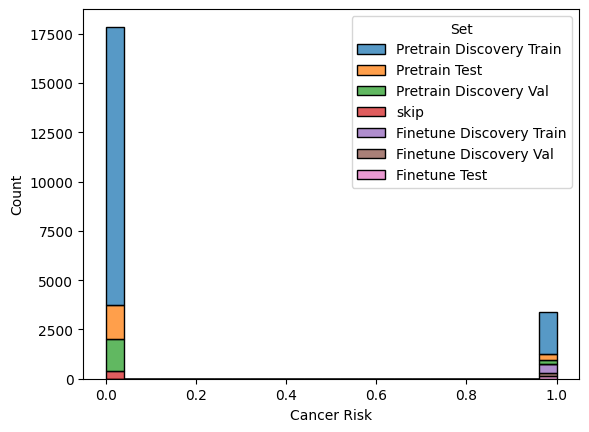

In [ ]:
sns.histplot(data=all_metadata,x='Cancer Risk', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Smoking Status', ylabel='Count'>

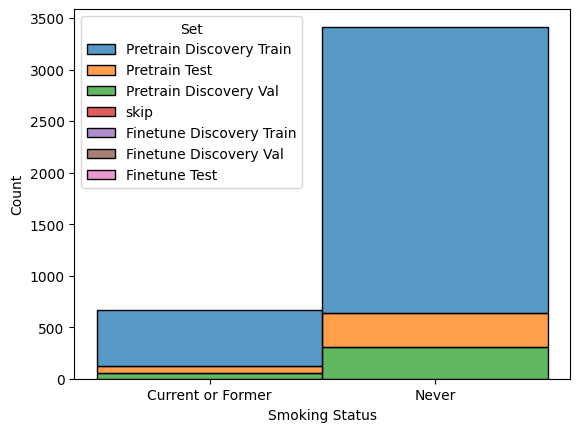

In [ ]:
sns.histplot(data=all_metadata,x='Smoking Status', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Sex', ylabel='Count'>

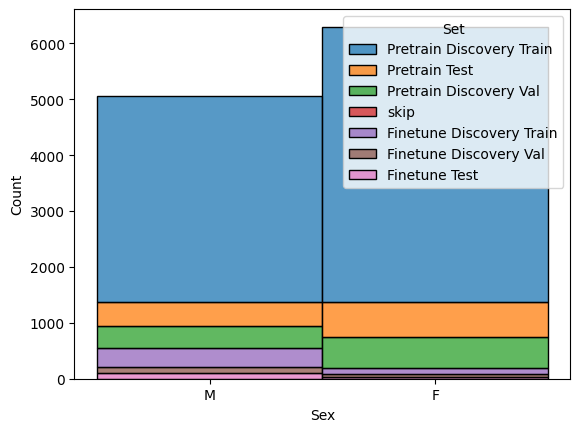

In [ ]:
sns.histplot(data=all_metadata,x='Sex', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='Age', ylabel='Count'>

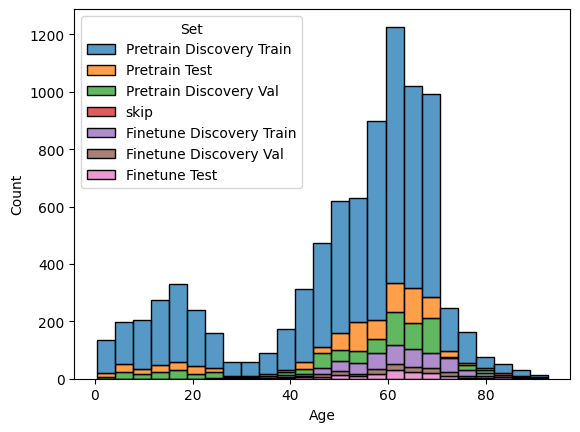

In [ ]:
sns.histplot(data=all_metadata,x='Age', hue = 'Set',multiple='stack',bins=25)

<Axes: xlabel='BMI', ylabel='Count'>

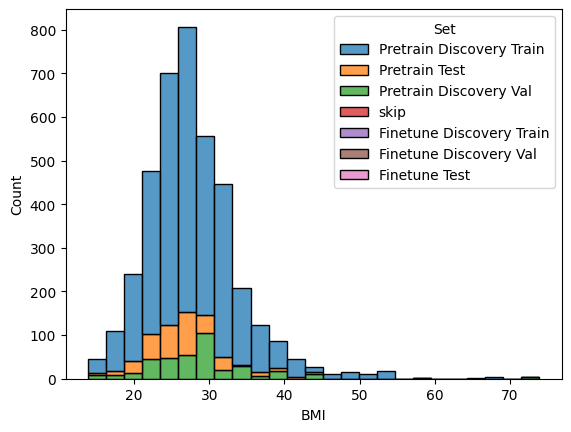

In [ ]:
sns.histplot(data=all_metadata,x='BMI', hue = 'Set',multiple='stack',bins=25)

In [ ]:
np.sum((all_metadata['BMI'] > 25) & (all_metadata['BMI'] < 30))

1455

In [ ]:
np.sum(all_metadata['BMI'] >30)

1173

<Axes: xlabel='Count', ylabel='Study ID'>

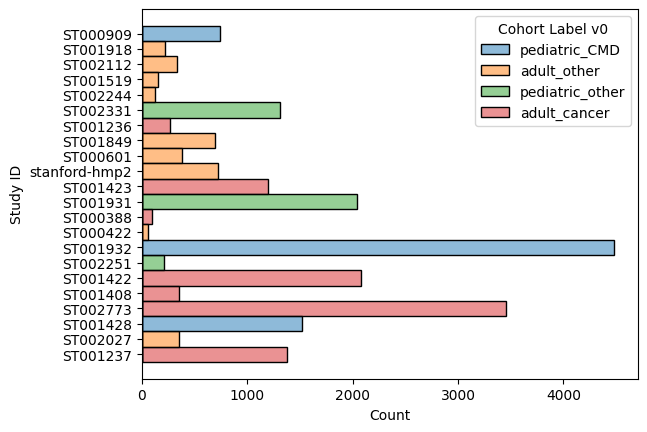

In [ ]:
sns.histplot(y='Study ID', hue='Cohort Label v0', data=all_metadata)